<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

<br>
<h1 style="font-family:verdana; font-size:26px"> <center>~ Notebook Penyisihan Intelecta Telkom University 2025 ~</center> </h1>
<br>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# **KantinBorju**

<p style = "font-size:16px; font-family:verdana">- Izhar Alif Akbar(Leader)<p>

<p style = "font-size:16px; font-family:verdana">- Farrel Athalla Putra <p>

<p style = "font-size:16px; font-family:verdana">- Razi Rachman Widyadhana <p>

<p style = "font-size:16px; font-family:verdana">- Muhammad Daffa Arrizki Yanma <p>

<br>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# ~ Notebook Contents ~

1. [**Introduction**](#1)

2. [**Exploratory Data Analysis**](#2)

3. [**Feature Engineering**](#3)

4. [**Modelling**](#4)

5. [**Reduplication & Submission**](#5)
   
6. [**Submission**](#6)

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Introduction <a name="1"></a>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## Permasalahan

*Stabilitas pasokan pangan dunia sangat bergantung pada iklim yang dapat diprediksi. Namun, perubahan iklim telah menciptakan tingkat ketidakpastian yang belum pernah terjadi sebelumnya, mengancam hasil panen dan mata pencaharian jutaan orang.*

*Tanpa pemahaman mendalam tentang faktor-faktor yang memengaruhi iklim, kerumitan data agrikultur dan lingkungan dapat menjadi tantangan bagi masyarakat. Badan Cuaca memerlukan analisis data yang tepat untuk mengidentifikasi variabel kunci iklim sehingga dapat menanggulangi bencana yang mungkin terjadi di masa depan.* 

*Dengan demikian, eksperimen ini berupaya **membangun model prediksi** untuk mengatasi permasalahan ini secara akurat yang dapat mengurai hubungan tersembunyi antara aktivitas manusia dan respons iklim.*

---

## Data Gathering

*Data untuk eksperimen ini bersumber dari dataset yang tersedia di platform **Kaggle**, khususnya dari kompetisi Intelecta Cup dengan pranala: https://www.kaggle.com/competitions/intelecta-cup-data-mining-competition/data*

*Dataset ini dirancang untuk melihat dampak perubahan iklim terhadap pertanian global. Data ini memungkinkan peneliti, data scientist, dan pembuat kebijakan untuk mengeksplorasi bagaimana variasi iklim mempengaruhi produksi pangan di berbagai wilayah.*

*Data ini difokuskan untuk memprediksi suhu rata-rata (Suhu_Rata_Rata_C) sebagai indikator utama perubahan iklim berdasarkan berbagai faktor lingkungan dan praktik pertanian*


### Atribut Data

1.  `ID`                : Identifier data

2.  `Tahun`             : Tahun pengumpulan data yang dimodelkan

3.  `Nama_Negara`       : Negara tempat data dikumpulkan

4.  `Wilayah`           : Wilayah geografis yang disimulasikan

5.  `Jenis_Tanaman`     : Jenis tanaman yang ditanam (gandum, jagung, padi, dll)

6.  `Total_Curah_Hujan_mm`      : Curah hujan tahunan yang dimodelkan (mm)

7.  `Emisi_CO2_JT_Ton`          : Tingkat emisi CO2 dalam juta ton

8.  `Hasil_Panen_Ton_per_HA`    : Data hasil panen sintetis untuk tanaman terpilih (ton/hektar)

9.  `Kejadian_Cuaca_Ekstrim`    : Jumlah kejadian cuaca ekstrem yang dimodelkan per tahun

10. `Akses_Irigasi`                     : Persentase akses terhadap sistem irigasi

11. `Penggunaan_Pestisida_KG_per_HA`    : Penggunaan pestisida dalam kg per hektar

12. `Penggunaan_Pupuk_KG_per_HA`        : Penggunaan pupuk dalam kg per hektar

13. `Indeks_Kesehatan_Tanah`            : Indeks kesehatan tanah (0-100)

14. `Strategi_Adaptasi`                 : Strategi adaptasi iklim yang diterapkan

15. `Suhu_Rata_Rata_C`                  : Target - Tingkat suhu rata-rata yang disimulasikan (°C)

---

## Pustaka

In [ ]:
import io
import math

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, boxcox_normmax, yeojohnson, probplot, norm
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\Razi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Konfigurasi

In [2]:
class Configs:
    SEED = 42
    SPLITS = 5

np.random.seed(Configs.SEED)
pd.set_option('display.max_columns', None)

rc_params = {
    "grid.color": "#EBEBE7",
    "font.family": "serif",
}

plt.rcParams.update(rc_params)
cmap = sns.diverging_palette(220, 20, as_cmap = True)

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Exploratory Data Analysis <a name="2"></a>

Analisis Data Eksplorasi (EDA) adalah proses pemeriksaan dan peringkasan dataset untuk mengungkap pola, tren, dan anomali. Dengan menggunakan visualisasi seperti histogram dan grafik lainnya, serta ukuran statistik seperti rata-rata dan korelasi.

EDA membantu memahami struktur data dan hubungan antar variabel. Proses ini mengidentifikasi outlier dan nilai yang hilang, memandu pembersihan data, serta memberikan wawasan untuk analisis atau pemodelan selanjutnya.

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## Data Loading

In [3]:
train = pd.read_csv('data/train.csv')
target = train['Suhu_Rata_Rata_C']
train = train.drop(columns=["ID"])

test = pd.read_csv('data/test.csv')
test_ids = test['ID']
test = test.drop(columns=["ID"])

In [4]:
train

,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Suhu_Rata_Rata_C
0,2015,USA,South,Soybeans,1658.71,13.36,2.620,10,74.41,38.97,2.64,46.07,Manajemen Air,20.43
1,2022,China,East,Wheat,1478.74,9.55,0.570,2,36.90,49.99,77.22,88.87,Rotasi Tanaman,-0.33
2,2000,India,'West Bengal',Fruits,1252.34,27.37,2.115,3,34.21,2.75,83.94,77.15,Pertanian Organik,12.97
3,2008,Nigeria,'North West',Sugarcane,209.89,16.16,4.158,5,91.74,36.80,37.50,73.59,Pertanian Organik,12.81
4,1991,Canada,Ontario,Vegetables,1086.67,3.71,2.430,0,14.72,7.22,28.72,41.90,Tanpa Adaptasi,4.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2022,Brazil,North,Rice,539.92,0.85,3.210,6,37.46,37.16,10.14,98.29,Tanaman Tahan Kekeringan,10.37
7996,2007,Australia,Victoria,Sugarcane,2687.50,14.22,0.640,0,29.75,32.75,80.77,62.92,Pertanian Organik,0.41
7997,2001,China,Central,Rice,2085.65,14.52,2.590,5,98.85,44.85,28.78,33.65,Manajemen Air,31.23
7998,2024,China,East,Barley,NaN,16.44,3.564,2,37.90,9.61,74.70,98.24,Tanaman Tahan Kekeringan,11.63


---

## Tipe Data tiap Fitur

In [5]:
buffer = io.StringIO()
train.info(buf=buffer)

lines = buffer.getvalue().splitlines()
types_info = (pd.DataFrame([x.split() for x in lines[5:-2]], columns=lines[3].split())).drop(['Count', 'Non-Null', '#'], axis=1)
types_info.set_index('Column')

,Dtype
Column,
Tahun,int64
Nama_Negara,object
Wilayah,object
Jenis_Tanaman,object
Total_Curah_Hujan_mm,float64
Emisi_CO2_JT_Ton,float64
Hasil_Panen_Ton_per_HA,float64
Kejadian_Cuaca_Ekstrim,int64
Akses_Irigasi,float64


---

## Unique Values

In [6]:
train.nunique().to_frame(name='nunique')

,nunique
Tahun,35
Nama_Negara,10
Wilayah,34
Jenis_Tanaman,10
Total_Curah_Hujan_mm,7681
Emisi_CO2_JT_Ton,2756
Hasil_Panen_Ton_per_HA,839
Kejadian_Cuaca_Ekstrim,11
Akses_Irigasi,5205
Penggunaan_Pestisida_KG_per_HA,3993


---

## Data Duplikat

In [7]:
train[train.duplicated(keep=False)]

,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Suhu_Rata_Rata_C


---

# Missing Values

In [8]:
missing_count = train.isnull().sum().rename('Missing Count')
missing_ratio = (train.isnull().mean()*100).rename('Missing Percentage (%)')
summary = missing_count.to_frame().join(missing_ratio.to_frame())
summary.sort_values(["Missing Percentage (%)"], ascending = [0])

,Missing Count,Missing Percentage (%)
Jenis_Tanaman,219,2.7375
Hasil_Panen_Ton_per_HA,200,2.5000
Akses_Irigasi,181,2.2625
Total_Curah_Hujan_mm,179,2.2375
Tahun,0,0.0000
Nama_Negara,0,0.0000
Wilayah,0,0.0000
Emisi_CO2_JT_Ton,0,0.0000
Kejadian_Cuaca_Ekstrim,0,0.0000
Penggunaan_Pestisida_KG_per_HA,0,0.0000


---

## Statistika Deskriptif

In [9]:
col = list(train.columns)
col.remove('Suhu_Rata_Rata_C')

num_features = []
cat_features = []

for i in col:
    if len(train[i].unique()) > 5 and train[i].dtype != 'object':
        num_features.append(i)
    else:
        cat_features.append(i)

print('Numerical Features: ', num_features)
print('Categorical Features: ', cat_features)

Numerical Features:  ['Tahun', 'Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'Kejadian_Cuaca_Ekstrim', 'Akses_Irigasi', 'Penggunaan_Pestisida_KG_per_HA', 'Penggunaan_Pupuk_KG_per_HA', 'Indeks_Kesehatan_Tanah']
Categorical Features:  ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']


### Kolom target `Suhu_Rata_Rata_C`

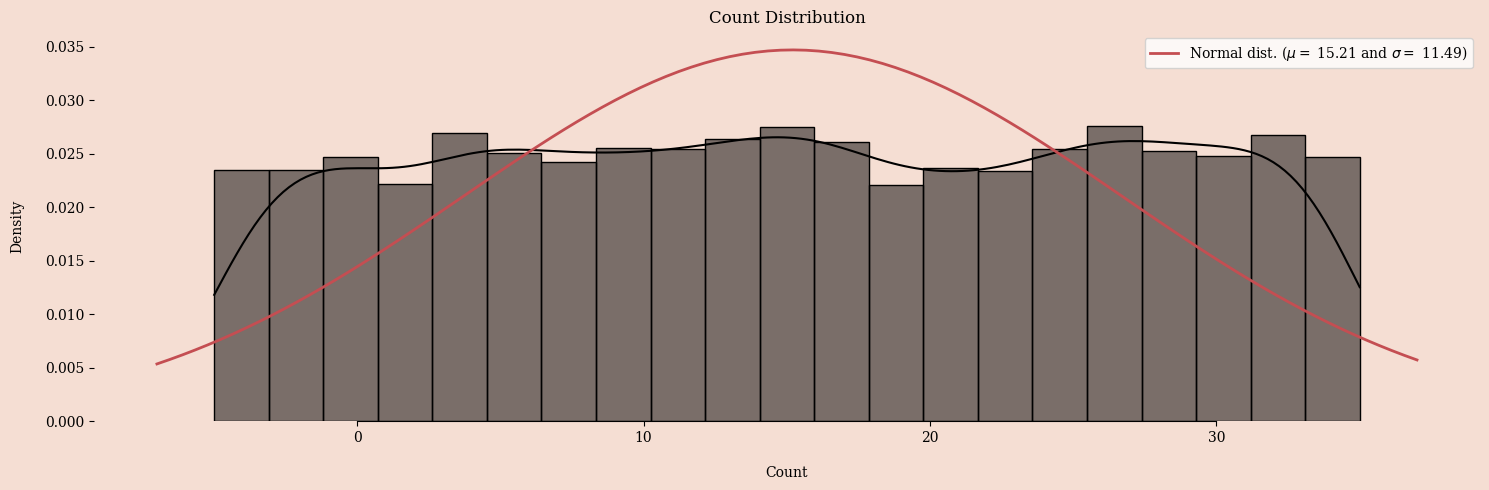

In [10]:
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(15, 5), facecolor='#f5ded3')
ax.set_facecolor('#f5ded3')

counts = train['Suhu_Rata_Rata_C'].values
sns.histplot(data=train, x='Suhu_Rata_Rata_C', kde=True, stat='density', color='#000000', ax=ax)

(mu, sigma) = norm.fit(counts)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
ax.plot(x, p, 'r-', linewidth=2, label=f'Normal dist. ($\\mu=$ {mu:.2f} and $\\sigma=$ {sigma:.2f})')

ax.legend(loc='best')
ax.xaxis.grid(False)
ax.set_ylabel("Density", labelpad=15)
ax.set_xlabel("Count", labelpad=15)
ax.set_title("Count Distribution")
sns.despine(trim=True, left=True)

plt.tight_layout()
plt.show()

### `num_features`

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Tahun,8000.0,2007.032750,10.106035,1990.00,1998.0000,2007.000,2016.0000,2024.00
Total_Curah_Hujan_mm,7821.0,1615.503060,807.932322,200.17,929.2900,1614.790,2316.8200,2999.67
Emisi_CO2_JT_Ton,8000.0,15.271184,8.551214,0.50,7.8600,15.250,22.8200,30.00
Hasil_Panen_Ton_per_HA,7800.0,2.238219,0.996626,0.45,1.4490,2.170,2.9300,5.00
Kejadian_Cuaca_Ekstrim,8000.0,4.989750,3.171814,0.00,2.0000,5.000,8.0000,10.00
Akses_Irigasi,7819.0,55.394575,26.034847,10.01,32.9050,55.340,77.7700,99.99
Penggunaan_Pestisida_KG_per_HA,8000.0,24.920015,14.454507,0.00,12.5500,24.930,37.3825,49.99
Penggunaan_Pupuk_KG_per_HA,8000.0,49.706654,28.674985,0.03,25.1600,49.270,74.4300,99.99
Indeks_Kesehatan_Tanah,8000.0,64.824446,20.153617,30.00,47.1150,64.675,82.3025,100.00
Suhu_Rata_Rata_C,8000.0,15.206680,11.490611,-4.99,5.3775,15.140,25.3400,35.00


### Insight

`Total_Curah_Hujan_mm` memiliki STD yang paling besar

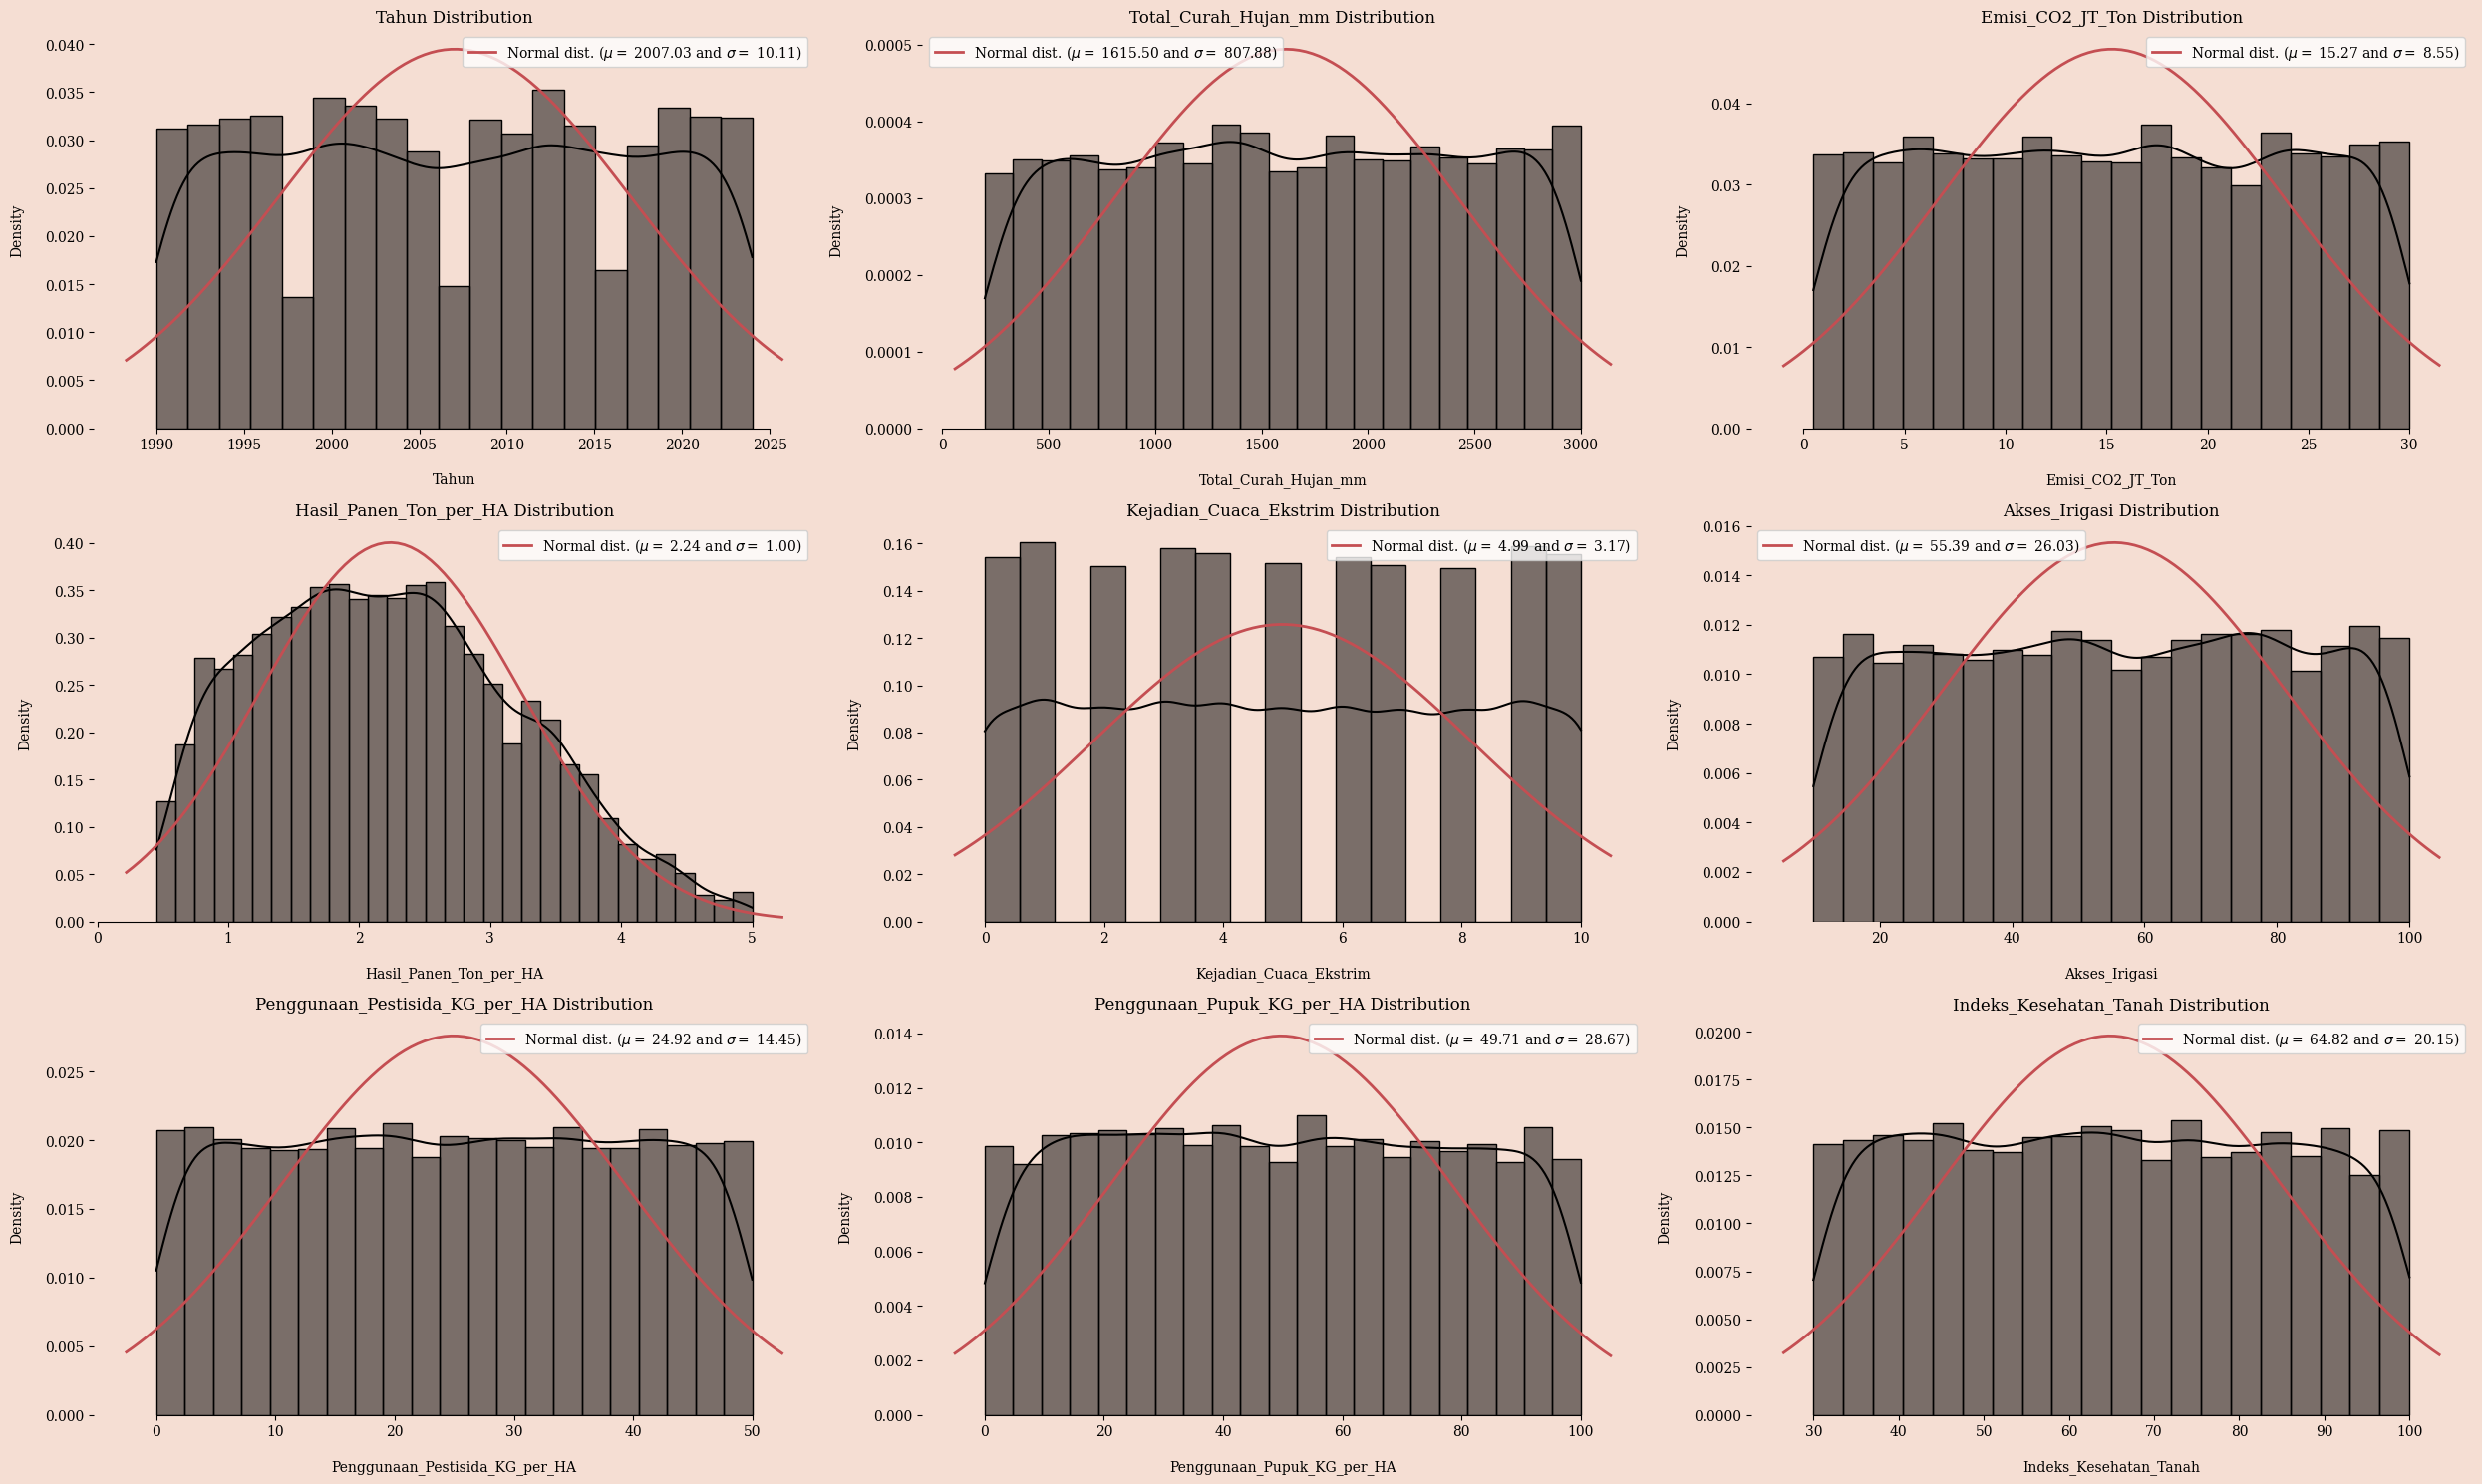

In [12]:
plt.figure(figsize=(25, 15), facecolor='#f5ded3')

for index, feature in enumerate(num_features):
    
    ax = plt.subplot(3, 3, index + 1)
    sns.histplot(data=train, x=feature, kde=True, stat='density', color='#000000', ax=ax)
    
    feature_data = train[feature].dropna()
    (mu, sigma) = norm.fit(feature_data)
    
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    
    ax.plot(x, p, 'r-', linewidth=2, label=f'Normal dist. ($\\mu=$ {mu:.2f} and $\\sigma=$ {sigma:.2f})')
    
    ax.legend(loc='best')
    ax.xaxis.grid(False)
    ax.set_facecolor('#f5ded3')
    ax.set_ylabel("Density", labelpad=15)
    ax.set_xlabel(feature, labelpad=15)  
    ax.set_title(f"{feature} Distribution")
    sns.despine(trim=True, left=True)

plt.tight_layout()
plt.show()

### `cat_features`

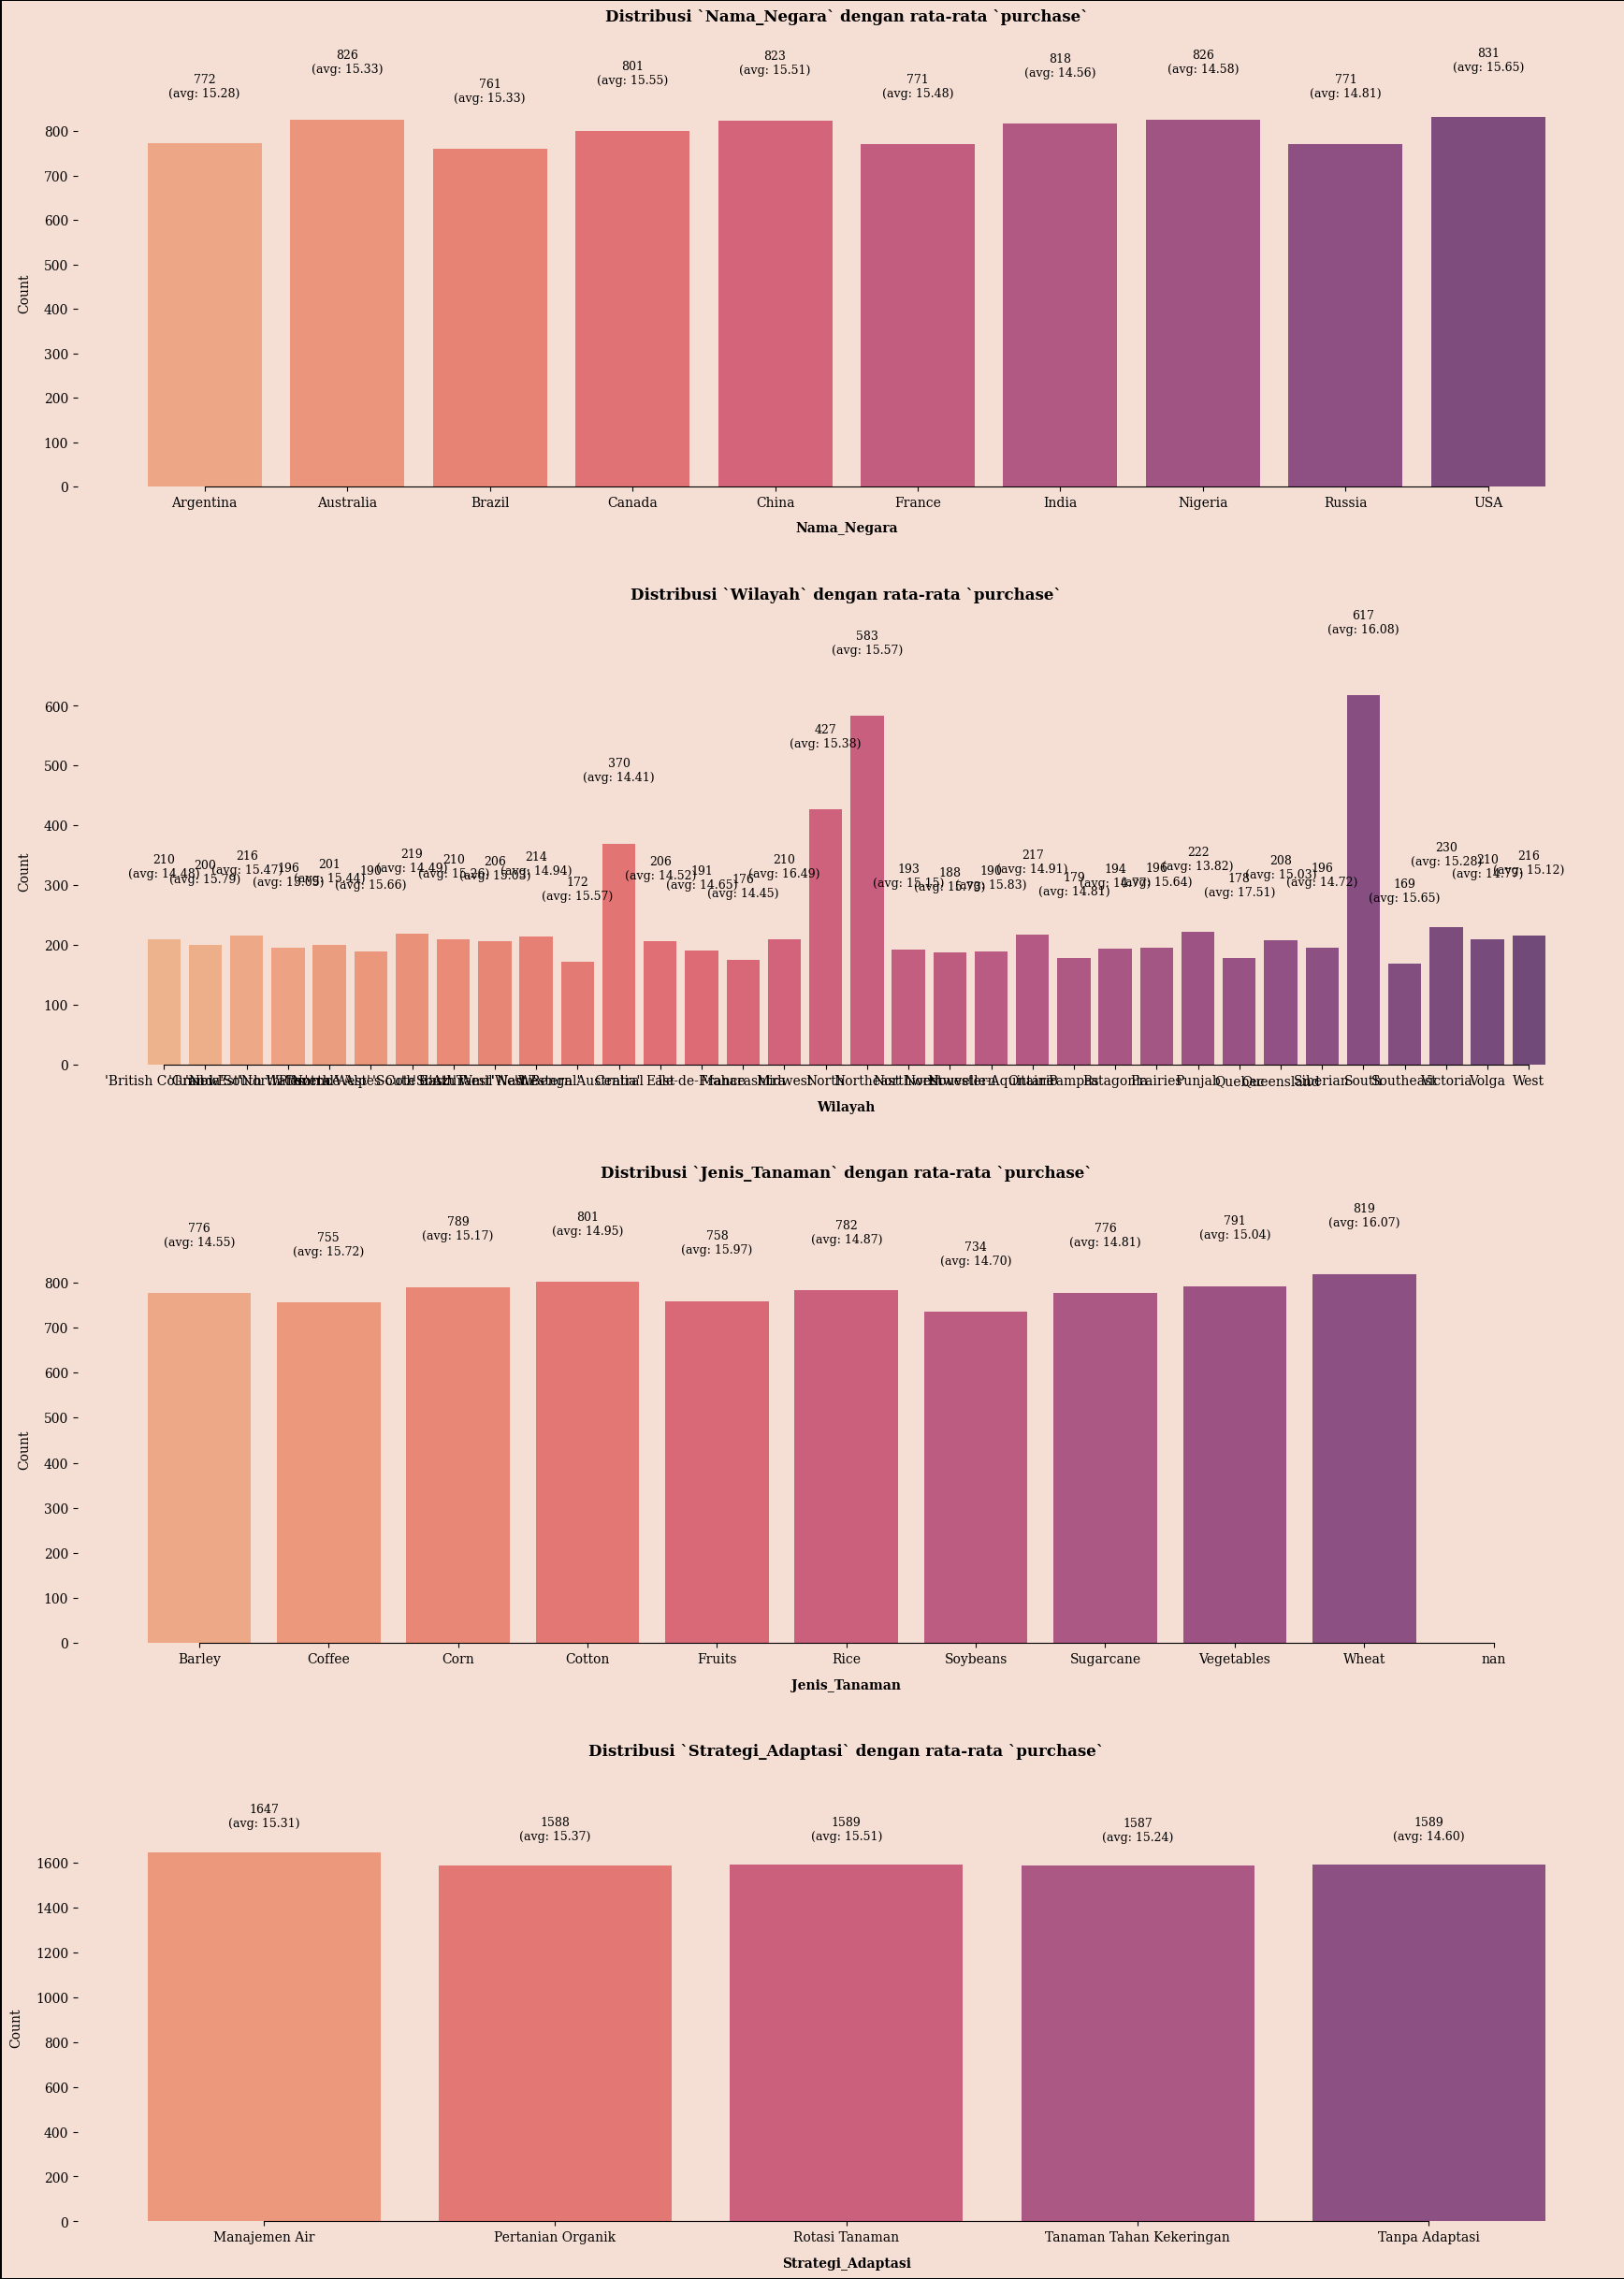

In [13]:
def plot_histogram(df, features, w, h, fs, space):

    n_features = len(features)
    n_rows = n_features
    n_cols = 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(w, h), facecolor='#f5ded3')
    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        ax = axes[i]
        
        # Get all unique categories
        all_categories = sorted(df[feature].unique(), key=str)
        
        # Calculate mean target value for each category
        category_means = df.groupby(feature)['Suhu_Rata_Rata_C'].mean().reindex(all_categories, fill_value=0)
        category_counts = df[feature].value_counts().reindex(all_categories, fill_value=0)
        
        x = np.arange(len(all_categories))
        
        # Create bar plot
        colors = sns.color_palette('flare', len(all_categories))
        bars = ax.bar(x, category_counts.values, color=colors, alpha=0.8)
        
        # Add count labels on top of bars
        for bar, count, mean_val in zip(bars, category_counts.values, category_means.values):
            height = bar.get_height()
            if height > 0:
                count_label = f'{int(count)}'
                mean_label = f'(avg: {mean_val:.2f})'
                ax.text(bar.get_x() + bar.get_width()/2., height + space, 
                    f'{count_label}\n{mean_label}', 
                    ha='center', va='bottom', fontsize=9)
        
        ax.set_title(f'Distribusi `{feature}` dengan rata-rata `purchase`', 
                    fontsize=fs, fontweight='bold', pad=60)
        ax.set_xlabel(feature, fontsize=fs-2, labelpad=10, fontweight='bold')
        ax.set_ylabel('Count', fontsize=fs-2, labelpad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(all_categories, fontsize=fs-2)
        ax.tick_params(axis='y', labelsize=fs-2)
        ax.set_facecolor('#f5ded3')
        
        sns.despine(ax=ax, trim=True, left=True)
    
    plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=2.0)
    plt.show()

plot_histogram(train, cat_features, 18, 25, 12, 100)

---

## Outliers?

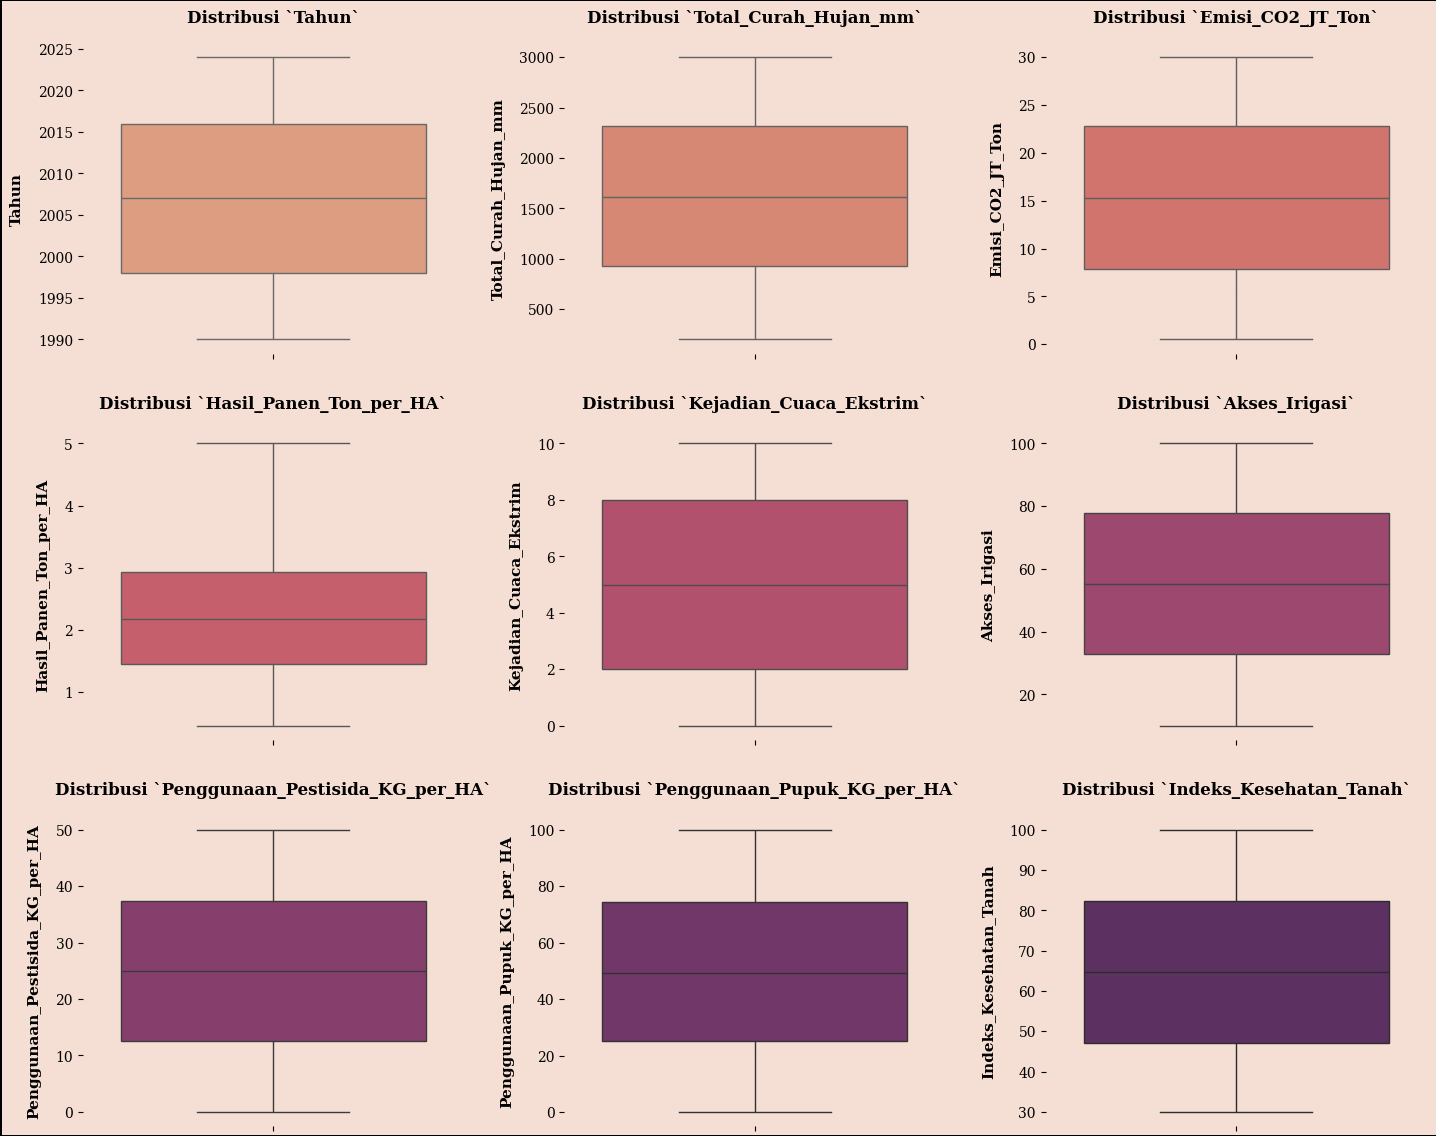

In [14]:
n_features = len(num_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), facecolor='#f5ded3')
fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')

if n_rows == 1:
    axes = axes if n_features > 1 else [axes]
else:
    axes = axes.flatten()

colors = sns.color_palette('flare', n_features)

for i, feature in enumerate(num_features):
    ax = axes[i]
    
    sns.boxplot(data=train, y=feature, palette=[colors[i]], ax=ax)
    
    ax.set_facecolor('#f5ded3')
    ax.set_title(f'Distribusi `{feature}`', fontsize=12, fontweight='bold', pad=15)
    ax.set_ylabel(feature, fontsize=11, fontweight='bold', labelpad=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    
    ax.set_xlabel('')
    
    ax.grid(True, alpha=0.3, axis='y')
    
    sns.despine(ax=ax, trim=True, left=True)

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)
plt.show()

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Preprocessing <a name="3"></a>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## 1. Handling Missing Values

Median imputation untuk numerik, 'Missing' untuk kategorikal

In [15]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.num_imputer = None
        self.cat_imputer = None
        self.numeric_features = None
        self.categorical_features = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']
    
    def fit(self, X, y=None):
        self.numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
        
        if self.numeric_features:
            self.num_imputer.fit(X[self.numeric_features])
        
        existing_cat_features = [f for f in self.categorical_features if f in X.columns]
        if existing_cat_features:
            self.cat_imputer.fit(X[existing_cat_features])
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy(deep=True)
        
        if self.numeric_features:
            X_transformed[self.numeric_features] = self.num_imputer.transform(X_transformed[self.numeric_features])
        
        existing_cat_features = [f for f in self.categorical_features if f in X_transformed.columns]
        if existing_cat_features:
            X_transformed[existing_cat_features] = self.cat_imputer.transform(X_transformed[existing_cat_features])
        
        return X_transformed

---

## 2. Log Transformations

Menerapkan log1p transformation untuk fitur skewed

In [16]:
class LogTransformation(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.skewed_features = [
            'Penggunaan_Pestisida_KG_per_HA',
            'Penggunaan_Pupuk_KG_per_HA',
            'Emisi_CO2_JT_Ton',
            'Hasil_Panen_Ton_per_HA'
        ]
        self.epsilon = 1e-6
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.skewed_features:
            if col in X_transformed.columns and pd.api.types.is_numeric_dtype(X_transformed[col]):
                min_val = X_transformed[col].min()
                if min_val <= 0:
                    X_transformed[f'{col}_log1p'] = np.log1p(X_transformed[col] - min_val + self.epsilon)
                else:
                    X_transformed[f'{col}_log1p'] = np.log1p(X_transformed[col])
        
        return X_transformed


<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Feature Engineering <a name="3"></a>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## 1. Binning Hasil Panen

Membuat binning untuk fitur kunci yang dapat membantu model menangkap non-linear threshold effects.

In [17]:
class FeatureBinning(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.epsilon = 1e-6
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Binning Hasil Panen (3 bins: Low, Medium, High)
        if 'Hasil_Panen_Ton_per_HA' in X_transformed.columns:
            bins = [-np.inf, 1.5, 3.0, np.inf]
            labels = ['Panen_Rendah', 'Panen_Sedang', 'Panen_Tinggi']
            X_transformed['Hasil_Panen_Bins'] = pd.cut(
                X_transformed['Hasil_Panen_Ton_per_HA'], 
                bins=bins, 
                labels=labels, 
                right=False
            )
            X_transformed['Hasil_Panen_Bins'] = X_transformed['Hasil_Panen_Bins'].astype(str).fillna('Missing_Bin')
        
        return X_transformed

---

## 2. Interaction Features

Membuat fitur interaksi kategorikal untuk menangkap efek kombinasi dari multiple categories.

In [18]:
class InteractionFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # 2-way interactions
        if 'Wilayah' in X_transformed.columns and 'Jenis_Tanaman' in X_transformed.columns:
            X_transformed['Wilayah_Tanaman'] = (
                X_transformed['Wilayah'].astype(str) + '_' + 
                X_transformed['Jenis_Tanaman'].astype(str)
            )
        
        if 'Nama_Negara' in X_transformed.columns and 'Jenis_Tanaman' in X_transformed.columns:
            X_transformed['Negara_Tanaman'] = (
                X_transformed['Nama_Negara'].astype(str) + '_' + 
                X_transformed['Jenis_Tanaman'].astype(str)
            )
        
        return X_transformed

## 3. Ratio Features

Membuat fitur rasio untuk capture efisiensi dan produktivitas

In [19]:
class RatioFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.epsilon = 1e-6
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Agricultural efficiency ratios
        if 'Penggunaan_Pupuk_KG_per_HA' in X_transformed.columns and 'Penggunaan_Pestisida_KG_per_HA' in X_transformed.columns:
            X_transformed['Pupuk_per_Pestisida'] = (
                X_transformed['Penggunaan_Pupuk_KG_per_HA'] / 
                (X_transformed['Penggunaan_Pestisida_KG_per_HA'] + self.epsilon)
            )
        
        if 'Hasil_Panen_Ton_per_HA' in X_transformed.columns and 'Total_Curah_Hujan_mm' in X_transformed.columns:
            X_transformed['Hasil_per_CurahHujan'] = (
                X_transformed['Hasil_Panen_Ton_per_HA'] / 
                (X_transformed['Total_Curah_Hujan_mm'] + self.epsilon)
            )
        
        if 'Emisi_CO2_JT_Ton' in X_transformed.columns and 'Hasil_Panen_Ton_per_HA' in X_transformed.columns:
            X_transformed['CO2_per_Hasil'] = (
                X_transformed['Emisi_CO2_JT_Ton'] / 
                (X_transformed['Hasil_Panen_Ton_per_HA'] + self.epsilon)
            )
        
        # Environmental interactions
        if 'Akses_Irigasi' in X_transformed.columns and 'Penggunaan_Pupuk_KG_per_HA' in X_transformed.columns:
            X_transformed['Irigasi_x_Pupuk'] = (
                X_transformed['Akses_Irigasi'] * 
                X_transformed['Penggunaan_Pupuk_KG_per_HA']
            )
        
        if 'Indeks_Kesehatan_Tanah' in X_transformed.columns and 'Akses_Irigasi' in X_transformed.columns:
            X_transformed['Soil_x_Irigasi'] = (
                X_transformed['Indeks_Kesehatan_Tanah'] * 
                X_transformed['Akses_Irigasi']
            )
        
        return X_transformed

---

## 4. Aggregation Features

Membuat aggregation dan deviation features untuk menangkap pola grup-level.

In [20]:
class AggregationFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.groupby_features = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Tahun']
        self.numeric_for_agg = ['Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton', 
                               'Hasil_Panen_Ton_per_HA', 'Indeks_Kesehatan_Tanah']
        self.agg_stats = {}
    
    def fit(self, X, y=None):
        
        for group_col in self.groupby_features:
            if group_col not in X.columns:
                continue
            
            for num_col in self.numeric_for_agg:
                if num_col not in X.columns:
                    continue
                
                for agg_type in ['mean', 'std', 'max', 'min']:
                    key = (group_col, num_col, agg_type)
                    
                    try:
                        if agg_type == 'std':
                            self.agg_stats[key] = X.groupby(group_col)[num_col].std().fillna(0)
                        else:
                            self.agg_stats[key] = X.groupby(group_col)[num_col].agg(agg_type)
                    except:
                        self.agg_stats[key] = None
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # apply aggregations
        for group_col in self.groupby_features:
            if group_col not in X_transformed.columns:
                continue
            
            for num_col in self.numeric_for_agg:
                if num_col not in X_transformed.columns:
                    continue
                
                # fill missing values dalam num_col
                X_transformed[num_col] = X_transformed[num_col].fillna(X_transformed[num_col].median())
                
                for agg_type in ['mean']:
                    new_col_name = f'agg_{group_col}_{num_col}_{agg_type}'
                    key = (group_col, num_col, agg_type)
                    
                    if key in self.agg_stats and self.agg_stats[key] is not None:
                        X_transformed[new_col_name] = X_transformed[group_col].map(self.agg_stats[key])
                        
                        # fill missing dengan median grup
                        group_median = X_transformed.groupby(group_col)[num_col].transform('median')
                        X_transformed[new_col_name] = X_transformed[new_col_name].fillna(group_median)
                    else:
                        X_transformed[new_col_name] = X_transformed[num_col].median()
        
        # create deviation features
        for group_col in self.groupby_features:
            if group_col not in X_transformed.columns:
                continue
            
            for num_col in self.numeric_for_agg:
                if num_col not in X_transformed.columns:
                    continue
                
                mean_col_name = f'agg_{group_col}_{num_col}_mean'
                if mean_col_name in X_transformed.columns:
                    dev_col_name = f'dev_{num_col}_from_{group_col}_mean'
                    
                    X_transformed[mean_col_name] = X_transformed[mean_col_name].fillna(X_transformed[mean_col_name].median())
                    X_transformed[dev_col_name] = X_transformed[num_col] - X_transformed[mean_col_name]
                    X_transformed[dev_col_name] = X_transformed[dev_col_name].fillna(0)
        
        return X_transformed


---

## 5. Column Name Cleaner

Membersihkan nama kolom untuk kompatibilitas dengan LightGBM

In [21]:
class ColumnNameCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.categorical_features = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 
                                    'Strategi_Adaptasi', 'Hasil_Panen_Bins',
                                    'Wilayah_Tanaman', 'Negara_Tanaman']
        self.column_mapping = {}
    
    def fit(self, X, y=None):
        # create mapping untuk clean column names
        numeric_cols = [col for col in X.columns if col not in self.categorical_features]
        
        self.column_mapping = {
            orig: "".join(c if c.isalnum() else "_" for c in str(orig))
            for orig in numeric_cols if isinstance(orig, (str, int, float))
        }
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # rename numeric columns
        X_transformed.rename(columns=self.column_mapping, inplace=True)
        
        # convert categorical to 'category' dtype untuk LGBM
        cat_features_for_lgbm = ['Wilayah', 'Jenis_Tanaman', 'Hasil_Panen_Bins']
        
        for col in cat_features_for_lgbm:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype('category')
        
        return X_transformed

---

## 6. Pipelining

In [22]:
preprocessing_pipeline = Pipeline([
    ('missing_values', MissingValueHandler()),
    ('log_transform', LogTransformation()),
    ('binning', FeatureBinning()),
    ('interactions', InteractionFeatures()),
    ('ratios', RatioFeatures()),
    # ('aggregations', AggregationFeatures()),
    ('clean_names', ColumnNameCleaner())
])

X_processed = preprocessing_pipeline.fit_transform(train.drop(columns=['Suhu_Rata_Rata_C']))
X_test_processed = preprocessing_pipeline.transform(test)

print(f"\n✓ Preprocessing completed!")
print(f"  Original features: {train.shape[1]}")
print(f"  After preprocessing: {X_processed.shape[1]}")
print(f"  New features created: {X_processed.shape[1] - train.shape[1]}")


✓ Preprocessing completed!
  Original features: 14
  After preprocessing: 25
  New features created: 11


In [23]:
X_processed

,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Penggunaan_Pestisida_KG_per_HA_log1p,Penggunaan_Pupuk_KG_per_HA_log1p,Emisi_CO2_JT_Ton_log1p,Hasil_Panen_Ton_per_HA_log1p,Hasil_Panen_Bins,Wilayah_Tanaman,Negara_Tanaman,Pupuk_per_Pestisida,Hasil_per_CurahHujan,CO2_per_Hasil,Irigasi_x_Pupuk,Soil_x_Irigasi
0,2015.0,USA,South,Soybeans,1658.71,13.36,2.620,10.0,74.41,38.97,2.64,46.07,Manajemen Air,3.688129,1.291984,2.664447,1.286474,Panen_Sedang,South_Soybeans,USA_Soybeans,0.067744,0.001580,5.099235,196.4424,3428.0687
1,2022.0,China,East,Wheat,1478.74,9.55,0.570,2.0,36.90,49.99,77.22,88.87,Rotasi Tanaman,3.931630,4.359525,2.356126,0.451076,Panen_Rendah,East_Wheat,China_Wheat,1.544709,0.000385,16.754357,2849.4180,3279.3030
2,2000.0,India,'West Bengal',Fruits,1252.34,27.37,2.115,3.0,34.21,2.75,83.94,77.15,Pertanian Organik,1.321756,4.441945,3.345332,1.136229,Panen_Sedang,'West Bengal'_Fruits,India_Fruits,30.523625,0.001689,12.940892,2871.5874,2639.3015
3,2008.0,Nigeria,'North West',Sugarcane,209.89,16.16,4.158,5.0,91.74,36.80,37.50,73.59,Pertanian Organik,3.632309,3.650658,2.842581,1.640549,Panen_Tinggi,'North West'_Sugarcane,Nigeria_Sugarcane,1.019022,0.019810,3.886483,3440.2500,6751.1466
4,1991.0,Canada,Ontario,Vegetables,1086.67,3.71,2.430,0.0,14.72,7.22,28.72,41.90,Tanpa Adaptasi,2.106570,3.391820,1.549688,1.232560,Panen_Sedang,Ontario_Vegetables,Canada_Vegetables,3.977839,0.002236,1.526748,422.7584,616.7680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2022.0,Brazil,North,Rice,539.92,0.85,3.210,6.0,37.46,37.16,10.14,98.29,Tanaman Tahan Kekeringan,3.641788,2.410542,0.615186,1.437463,Panen_Tinggi,North_Rice,Brazil_Rice,0.272874,0.005945,0.264797,379.8444,3681.9434
7996,2007.0,Australia,Victoria,Sugarcane,2687.50,14.22,0.640,0.0,29.75,32.75,80.77,62.92,Pertanian Organik,3.518980,4.403910,2.722610,0.494696,Panen_Rendah,Victoria_Sugarcane,Australia_Sugarcane,2.466259,0.000238,22.218715,2402.9075,1871.8700
7997,2001.0,China,Central,Rice,2085.65,14.52,2.590,5.0,98.85,44.85,28.78,33.65,Manajemen Air,3.825375,3.393837,2.742130,1.278152,Panen_Sedang,Central_Rice,China_Rice,0.641695,0.001242,5.606175,2844.9030,3326.3025
7998,2024.0,China,East,Barley,1614.79,16.44,3.564,2.0,37.90,9.61,74.70,98.24,Tanaman Tahan Kekeringan,2.361797,4.326778,2.858766,1.518199,Panen_Tinggi,East_Barley,China_Barley,7.773152,0.002207,4.612793,2831.1300,3723.2960


---

## 7. Feature Selection

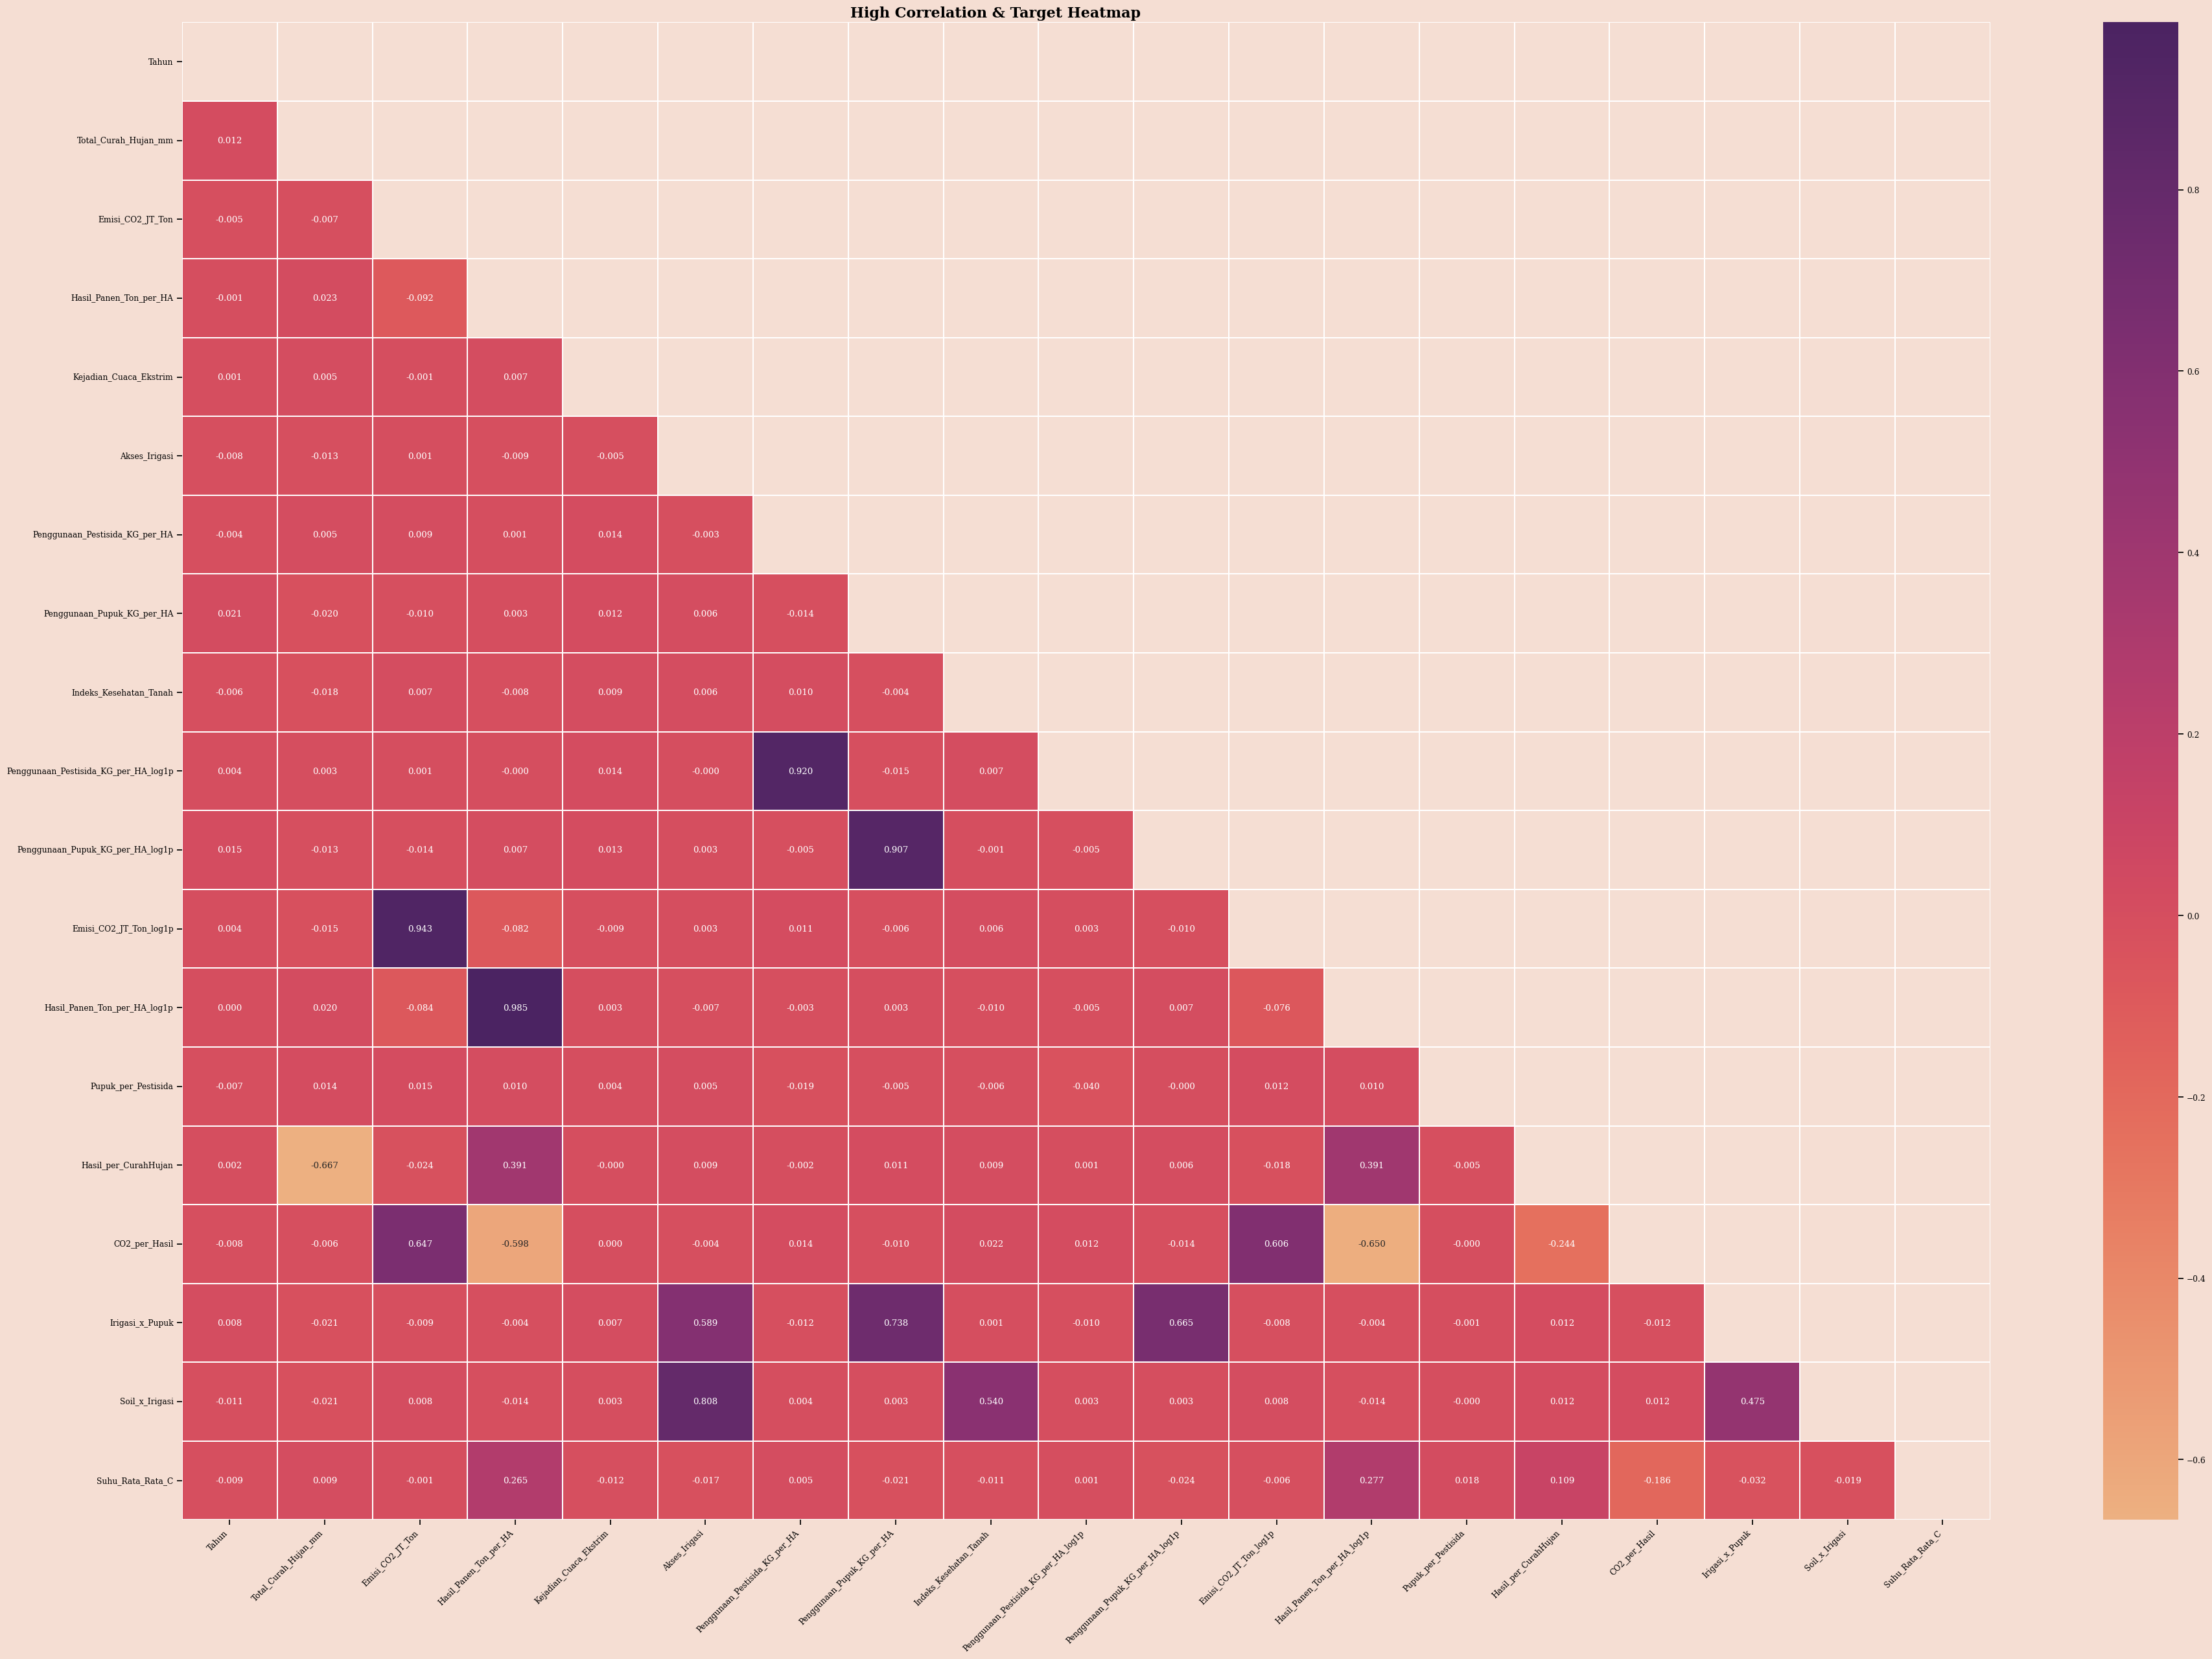

In [24]:
def mask_corr_matrix(df, p, t):
    
    plt.figure(figsize = (p,t), facecolor='#f5ded3')
    temp = df.copy(deep = True)

    corr = temp.corr()
    filter = np.zeros_like(corr, dtype=bool)

    half = np.triu(np.ones_like(corr, dtype=bool))
    sns.set_context("notebook", font_scale=0.8)
    
    heatmap = sns.heatmap(corr, mask = filter | half, annot=True, fmt=".3f", cmap = 'flare', linewidths=0.2, xticklabels=True, yticklabels=True)
    
    title = heatmap.set_title("High Correlation & Target Heatmap", weight='bold', size=16)
    title.set_position([0.45, 1.1])
    heatmap.set_facecolor('#f5ded3')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

X_processed['Suhu_Rata_Rata_C'] = target
mask_corr_matrix(X_processed.select_dtypes(include=[np.number]), 45, 30)

---

## 7. Target Encoding

Menerapkan Target Encoding dengan smoothing untuk fitur kategorikal
yang memiliki high cardinality. Target encoding dilakukan setelah
preprocessing pipeline untuk menghindari data leakage.

In [25]:
# Fitur kategorikal untuk Target Encoding (high cardinality)
CAT_FEATURES_FOR_TE = ['Nama_Negara', 'Strategi_Adaptasi', 'Wilayah_Tanaman', 'Negara_Tanaman', 'Hasil_Panen_Bins']

# Fitur kategorikal untuk LGBM (akan ditangani langsung oleh LGBM)
CAT_FEATURES_FOR_LGBM = ['Wilayah', 'Jenis_Tanaman']

print(f"Features for Target Encoding: {CAT_FEATURES_FOR_TE}")
print(f"Features for LGBM categorical: {CAT_FEATURES_FOR_LGBM}")

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer untuk Target Encoding dengan smoothing.
    Smoothing membantu prevent overfitting pada kategori dengan sample kecil.
    """
    
    def __init__(self, cat_features, smoothing=10):
        self.cat_features = cat_features
        self.smoothing = smoothing
        self.global_mean = None
        self.mappings = {}
    
    def fit(self, X, y):
        self.global_mean = y.mean()
        
        for col in self.cat_features:
            if col not in X.columns:
                continue
            
            try:
                # Create dataframe untuk groupby
                temp_df = pd.DataFrame({col: X[col], 'target': y})
                
                if temp_df[col].nunique() < 2:
                    self.mappings[col] = pd.Series(self.global_mean, index=temp_df[col].unique())
                    continue
                
                # Compute smoothed encoding
                agg = temp_df.groupby(col)['target'].agg(['count', 'mean'])
                counts = agg['count']
                means = agg['mean']
                smooth = (counts * means + self.smoothing * self.global_mean) / (counts + self.smoothing)
                self.mappings[col] = smooth
                
            except Exception as e:
                print(f"  ⚠️  Error encoding '{col}': {e}")
                self.mappings[col] = pd.Series(self.global_mean, index=X[col].unique())
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.cat_features:
            if col in X_transformed.columns and col in self.mappings:
                X_transformed[col] = X_transformed[col].astype(str).map(
                    self.mappings[col].astype(str)
                )
                X_transformed[col].fillna(self.global_mean, inplace=True)
        
        return X_transformed

# Apply target encoding
target_encoder = TargetEncoder(CAT_FEATURES_FOR_TE, smoothing=10)
X = target_encoder.fit_transform(X_processed, target)
X_test = target_encoder.transform(X_test_processed)

# Ensure category dtype untuk LGBM features
for col in CAT_FEATURES_FOR_LGBM:
    if col in X.columns:
        X[col] = X[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

print(f"\n✓ Target encoding applied to {len(CAT_FEATURES_FOR_TE)} features")


Features for Target Encoding: ['Nama_Negara', 'Strategi_Adaptasi', 'Wilayah_Tanaman', 'Negara_Tanaman', 'Hasil_Panen_Bins']
Features for LGBM categorical: ['Wilayah', 'Jenis_Tanaman']

✓ Target encoding applied to 5 features


In [26]:
X

,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Penggunaan_Pestisida_KG_per_HA_log1p,Penggunaan_Pupuk_KG_per_HA_log1p,Emisi_CO2_JT_Ton_log1p,Hasil_Panen_Ton_per_HA_log1p,Hasil_Panen_Bins,Wilayah_Tanaman,Negara_Tanaman,Pupuk_per_Pestisida,Hasil_per_CurahHujan,CO2_per_Hasil,Irigasi_x_Pupuk,Soil_x_Irigasi,Suhu_Rata_Rata_C
0,2015.0,15.640352913198573,South,Soybeans,1658.71,13.36,2.620,10.0,74.41,38.97,2.64,46.07,15.313021605310803,3.688129,1.291984,2.664447,1.286474,14.643878600723763,14.554648484848485,14.62051111111111,0.067744,0.001580,5.099235,196.4424,3428.0687,20.43
1,2022.0,15.504942136854742,East,Wheat,1478.74,9.55,0.570,2.0,36.90,49.99,77.22,88.87,15.507221263289557,3.931630,4.359525,2.356126,0.451076,11.624108180943216,14.152154838709679,15.56221224489796,1.544709,0.000385,16.754357,2849.4180,3279.3030,-0.33
2,2000.0,14.563063768115942,'West Bengal',Fruits,1252.34,27.37,2.115,3.0,34.21,2.75,83.94,77.15,15.366994242803504,1.321756,4.441945,3.345332,1.136229,14.643878600723763,17.0156,15.708520000000002,30.523625,0.001689,12.940892,2871.5874,2639.3015,12.97
3,2008.0,14.584661244019138,'North West',Sugarcane,209.89,16.16,4.158,5.0,91.74,36.80,37.50,73.59,15.366994242803504,3.632309,3.650658,2.842581,1.640549,20.617524515772,13.93325714285714,14.209781132075474,1.019022,0.019810,3.886483,3440.2500,6751.1466,12.81
4,1991.0,15.549860419235513,Ontario,Vegetables,1086.67,3.71,2.430,0.0,14.72,7.22,28.72,41.90,14.599866666666667,2.106570,3.391820,1.549688,1.232560,14.643878600723763,16.75314117647059,13.696241860465117,3.977839,0.002236,1.526748,422.7584,616.7680,4.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2022.0,15.331902464332037,North,Rice,539.92,0.85,3.210,6.0,37.46,37.16,10.14,98.29,15.24258409517846,3.641788,2.410542,0.615186,1.437463,20.617524515772,14.54567659574468,15.012421917808219,0.272874,0.005945,0.264797,379.8444,3681.9434,10.37
7996,2007.0,15.324493779904309,Victoria,Sugarcane,2687.50,14.22,0.640,0.0,29.75,32.75,80.77,62.92,15.366994242803504,3.518980,4.403910,2.722610,0.494696,11.624108180943216,14.887071999999998,15.241424390243903,2.466259,0.000238,22.218715,2402.9075,1871.8700,0.41
7997,2001.0,15.504942136854742,Central,Rice,2085.65,14.52,2.590,5.0,98.85,44.85,28.78,33.65,15.313021605310803,3.825375,3.393837,2.742130,1.278152,14.643878600723763,15.385979310344828,14.536448351648353,0.641695,0.001242,5.606175,2844.9030,3326.3025,31.23
7998,2024.0,15.504942136854742,East,Barley,1614.79,16.44,3.564,2.0,37.90,9.61,74.70,98.24,15.24258409517846,2.361797,4.326778,2.858766,1.518199,20.617524515772,15.619296969696968,16.563181609195404,7.773152,0.002207,4.612793,2831.1300,3723.2960,11.63


In [27]:
X_test

,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Penggunaan_Pestisida_KG_per_HA_log1p,Penggunaan_Pupuk_KG_per_HA_log1p,Emisi_CO2_JT_Ton_log1p,Hasil_Panen_Ton_per_HA_log1p,Hasil_Panen_Bins,Wilayah_Tanaman,Negara_Tanaman,Pupuk_per_Pestisida,Hasil_per_CurahHujan,CO2_per_Hasil,Irigasi_x_Pupuk,Soil_x_Irigasi
0,2022.0,14.817614340588989,Central,Fruits,1173.04,10.29,2.440,3.0,59.17,29.17,80.06,74.93,14.599866666666667,3.406848,4.395190,2.423917,1.235471,14.643878600723763,14.89810909090909,15.386750617283951,2.744601,0.002080,4.217211,4737.1502,4433.6081
1,1993.0,15.331902464332037,South,Rice,310.08,13.90,3.276,2.0,60.59,4.76,70.63,97.59,14.599866666666667,1.750938,4.271514,2.701361,1.453018,20.617524515772,16.504168749999998,15.012421917808219,14.838232,0.010565,4.242978,4279.4717,5912.9781
2,1998.0,14.563063768115942,Maharashtra,Soybeans,1348.17,12.90,2.620,3.0,90.93,5.95,63.87,74.81,15.24258409517846,1.938742,4.172385,2.631889,1.286474,14.643878600723763,14.878606451612903,14.847900000000001,10.734452,0.001943,4.923662,5807.6991,6802.4733
3,2010.0,14.817614340588989,Volga,Soybeans,1732.43,23.82,3.717,4.0,35.11,7.49,81.81,87.01,15.507221263289557,2.138889,4.416549,3.211650,1.551173,20.617524515772,15.780957142857144,13.10884938271605,10.922562,0.002146,6.408392,2872.3491,3054.9211
4,1998.0,15.549860419235513,'British Columbia',Sugarcane,2242.77,28.92,2.034,6.0,68.75,43.35,48.14,64.22,15.313021605310803,3.792113,3.894673,3.398527,1.109882,14.643878600723763,12.250234482758621,14.077216438356164,1.110496,0.000907,14.218282,3309.6250,4415.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1993.0,14.584661244019138,'North West',Cotton,2987.93,12.82,2.040,3.0,54.54,2.18,75.93,61.03,15.313021605310803,1.156882,4.342896,2.626117,1.111858,14.643878600723763,16.067638709677418,14.29624255319149,34.830259,0.000683,6.284311,4141.2222,3328.5762
1996,2000.0,15.331902464332037,North,Corn,878.80,2.82,1.920,8.0,91.63,7.15,50.57,61.61,15.366994242803504,2.098018,3.942940,1.340250,1.071584,14.643878600723763,14.613536,16.13859789473684,7.072726,0.002185,1.468749,4633.7291,5645.3243
1997,2023.0,15.504942136854742,East,Fruits,1858.37,29.98,1.926,2.0,72.31,46.20,22.35,52.12,15.24258409517846,3.854394,3.150597,3.433342,1.073636,14.643878600723763,14.73551304347826,15.094957894736842,0.483766,0.001036,15.565932,1616.1285,3768.7972
1998,1999.0,14.584661244019138,'North West',Soybeans,2307.96,0.99,0.960,4.0,36.41,21.31,9.13,47.08,15.507221263289557,3.105035,2.315501,0.688135,0.672944,11.624108180943216,17.015072,14.9431306122449,0.428437,0.000416,1.031249,332.4233,1714.1828


<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Modelling <a name="4"></a>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## Desain Eksperimen

Persiapan untuk modeling termasuk:
- Definisi metrik evaluasi (MAPE)
- Pembuatan sample weights (WMAE)
- Stratifikasi bins untuk cross-validation

In [28]:
def robust_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error dengan handling untuk nilai nol."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true)
    denominator = np.where(denominator < 1e-9, 1e-9, denominator)
    
    try:
        errors = np.abs(y_true - y_pred) / denominator
    except ValueError:
        return np.inf
    
    return np.mean(errors)

def lgbm_mape_eval(y_true, y_pred):
    """Custom eval metric untuk LightGBM."""
    mape = robust_mape(y_true, y_pred)
    return 'mape', mape, False

print("  ✓ Metrik evaluasi: MAPE (Mean Absolute Percentage Error)")


weights_wmae = 1.0 / (np.abs(target) + 1e-9)
max_weight_99 = np.quantile(weights_wmae, 0.99)
weights = np.clip(weights_wmae, 0, max_weight_99)

print(f"  ✓ Weights created (clipped at 99th percentile)")
print(f"    Min: {weights.min():.4f}, Max: {weights.max():.4f}, Mean: {weights.mean():.4f}")


abs_y = np.abs(target)
try:
    y_bins_5 = pd.qcut(abs_y, 5, labels=False, duplicates='drop')
    y_bins_10 = pd.qcut(abs_y.rank(method='first'), 10, labels=False, duplicates='drop')
except ValueError:
    y_bins_5 = pd.qcut(abs_y.rank(method='first'), 5, labels=False, duplicates='drop')
    y_bins_10 = pd.qcut(abs_y.rank(method='first'), 10, labels=False, duplicates='drop')

print(f"  ✓ 5-bins created untuk hyperparameter tuning")
print(f"  ✓ 10-bins created untuk final model training")


  ✓ Metrik evaluasi: MAPE (Mean Absolute Percentage Error)
  ✓ Weights created (clipped at 99th percentile)
    Min: 0.0286, Max: 5.0000, Mean: 0.2502
  ✓ 5-bins created untuk hyperparameter tuning
  ✓ 10-bins created untuk final model training


---

## Hyperparameter Tuning

Menggunakan Optuna untuk mencari hyperparameter optimal LightGBM.
Optimasi dilakukan dengan 5-fold stratified cross-validation menggunakan:
- Objective: MAE (L1 loss) untuk robust terhadap outliers
- Metrik evaluasi: MAPE (Mean Absolute Percentage Error)
- Sample weights: WMAE (Weighted MAE)
- Stratifikasi: Berdasarkan bins absolute value target

Hyperparameter yang di-tune:
- learning_rate: Learning rate untuk gradient boosting
- num_leaves: Jumlah leaves di setiap tree
- feature_fraction: Fraksi features untuk setiap iteration
- bagging_fraction: Fraksi data untuk bagging
- lambda_l1, lambda_l2: Regularization parameters
- min_child_samples: Minimum samples per leaf

In [29]:
TARGET = 'Suhu_Rata_Rata_C'

# --- Hitung Global TE Mappings SEKARANG ---
print("Menghitung Global Target Encoding Mappings (Smoothed)...")
global_mappings_smooth = {}
global_mean_y = target.mean()
# Gabungkan X asli (sebelum TE) dan y asli untuk mapping global
train_data_full_orig = train
smoothing_factor = 10 # Faktor smoothing

Menghitung Global Target Encoding Mappings (Smoothed)...


In [30]:
for col in CAT_FEATURES_FOR_TE: # Hanya encode fitur TE
    if col not in train_data_full_orig.columns: continue
    if TARGET not in train_data_full_orig.columns: continue
    try:
        if train_data_full_orig[col].nunique() < 2:
             all_categories = pd.concat([train[col], test[col]]).unique()
             global_mappings_smooth[col] = pd.Series(global_mean_y, index=all_categories)
             continue
        agg = train_data_full_orig.groupby(col)[TARGET].agg(['count', 'mean'])
        counts = agg['count']; means = agg['mean']
        smooth = (counts * means + smoothing_factor * global_mean_y) / (counts + smoothing_factor)
        global_mappings_smooth[col] = smooth
    except Exception as e:
        print(f"Error mapping global '{col}': {e}")
        all_categories = pd.concat([train[col], test[col]]).unique()
        global_mappings_smooth[col] = pd.Series(global_mean_y, index=all_categories)


# --- Terapkan Global TE ke X dan X_test ---
X_glob_te = X.drop(columns=[TARGET]).copy(deep = True)
X_test_glob_te = X_test.copy(deep = True)

print("Menerapkan Global TE ke X_train dan X_test...")
for col in CAT_FEATURES_FOR_TE: # Hanya encode fitur TE
    # Cek di X_glob_te
    if col in X_glob_te.columns:
        if col in global_mappings_smooth:
            map_series = global_mappings_smooth[col]
            source_dtype = X_glob_te[col].dtype
            target_index_dtype = map_series.index.dtype
            if pd.api.types.is_string_dtype(target_index_dtype) and not pd.api.types.is_string_dtype(source_dtype) :
                 X_glob_te[col] = X_glob_te[col].astype(str).map(map_series)
            elif source_dtype == target_index_dtype: X_glob_te[col] = X_glob_te[col].map(map_series)
            else:
                 try: X_glob_te[col] = X_glob_te[col].map(map_series)
                 except TypeError:
                      map_series.index = map_series.index.astype(str)
                      X_glob_te[col] = X_glob_te[col].astype(str).map(map_series)
            X_glob_te[col].fillna(global_mean_y, inplace=True)
        else: X_glob_te[col] = global_mean_y
    # Cek di X_test_glob_te
    if col in X_test_glob_te.columns:
         if col in global_mappings_smooth:
             map_series = global_mappings_smooth[col]
             source_dtype = X_test_glob_te[col].dtype
             target_index_dtype = map_series.index.dtype
             if pd.api.types.is_string_dtype(target_index_dtype) and not pd.api.types.is_string_dtype(source_dtype):
                  X_test_glob_te[col] = X_test_glob_te[col].astype(str).map(map_series)
             elif source_dtype == target_index_dtype: X_test_glob_te[col] = X_test_glob_te[col].map(map_series)
             else:
                  try: X_test_glob_te[col] = X_test_glob_te[col].map(map_series)
                  except TypeError:
                       map_series.index = map_series.index.astype(str)
                       X_test_glob_te[col] = X_test_glob_te[col].astype(str).map(map_series)
             X_test_glob_te[col].fillna(global_mean_y, inplace=True)
         else: X_test_glob_te[col] = global_mean_y


# Pastikan tipe data 'category' untuk LGBM di X_glob_te dan X_test_glob_te
for col in CAT_FEATURES_FOR_LGBM:
    if col in X_glob_te.columns: X_glob_te[col] = X_glob_te[col].astype('category')
    if col in X_test_glob_te.columns: X_test_glob_te[col] = X_test_glob_te[col].astype('category')

print("Global TE selesai.")


# 4. Hyperparameter Tuning (Optuna) pada Data Global TE
print("\nMemulai Hyperparameter Tuning BARU (WMAE + FE Final)...")

def lgb_objective(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.9),
        'bagging_freq': 1,
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 20.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 20.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'verbose': -1, 'n_jobs': -1, 'seed': trial.suggest_int('seed', 1, 1000)
    }

    kf_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_mapes = []
    y_original_eval = target.copy()

    for fold, (train_index, val_index) in enumerate(kf_tune.split(X_glob_te, y_bins_5)):
        X_train, X_val = X_glob_te.iloc[train_index], X_glob_te.iloc[val_index]
        y_train = y_original_eval.iloc[train_index]
        y_val = y_original_eval.iloc[val_index]
        train_weights = weights.iloc[train_index]
        try: val_weights = weights.loc[X_val.index]
        except KeyError: val_weights = np.full(len(X_val), weights.mean())

        model = lgb.LGBMRegressor(**params)
        try:
            model.fit(X_train, y_train,
                      sample_weight=train_weights, eval_set=[(X_val, y_val)],
                      eval_sample_weight=[val_weights], eval_metric=lgbm_mape_eval,
                      callbacks=[lgb.early_stopping(100, verbose=False)],
                      categorical_feature=CAT_FEATURES_FOR_LGBM # Beri tahu LGBM
                      )
            val_preds = model.predict(X_val)
            fold_mape_val = robust_mape(y_val, val_preds)
            if np.isnan(fold_mape_val) or np.isinf(fold_mape_val): fold_mapes.append(1e9)
            else: fold_mapes.append(fold_mape_val)
        except Exception as e:
            print(f"Error during Optuna fit/predict fold {fold}: {e}")
            fold_mapes.append(1e9)

    if not fold_mapes or all(np.isinf(f) or np.isnan(f) or f >= 1e9 for f in fold_mapes) : return 1e9
    return np.mean([f for f in fold_mapes if not (np.isinf(f) or np.isnan(f))])


N_TRIALS = 20
study = optuna.create_study(direction='minimize')
try:
    study.optimize(lgb_objective, n_trials=N_TRIALS)
    BEST_LGB_PARAMS = study.best_params
    best_value_optuna = study.best_value
except Exception as e:
    print(f"Optuna optimization failed: {e}")
    BEST_LGB_PARAMS = { # Fallback
        'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 0.8,
        'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
        'min_child_samples': 20, 'seed': 42
    }
    BEST_LGB_PARAMS.pop('seed', None)
    best_value_optuna = -1

final_seed = BEST_LGB_PARAMS.pop('seed') if 'seed' in BEST_LGB_PARAMS and best_value_optuna != -1 else 42
BEST_LGB_PARAMS.update({
    'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 3000,
    'verbose': -1, 'n_jobs': -1, 'seed': final_seed,
})

if best_value_optuna != -1: print(f"Tuning Final Selesai. MAPE terbaik (CV-5 Stratified): {best_value_optuna * 100:.4f}%")
else: print("Tuning Optuna Gagal.")
print(f"Parameter LGBM terbaik FINAL ditemukan: {BEST_LGB_PARAMS}")


[I 2025-10-30 17:40:52,598] A new study created in memory with name: no-name-274b6eac-2de6-40c2-9b31-ac218273da34


Menerapkan Global TE ke X_train dan X_test...
Global TE selesai.

Memulai Hyperparameter Tuning BARU (WMAE + FE Final)...


[I 2025-10-30 17:41:00,481] Trial 0 finished with value: 0.9033746611782215 and parameters: {'learning_rate': 0.006286619938968213, 'num_leaves': 63, 'feature_fraction': 0.559289592588966, 'bagging_fraction': 0.582677915579402, 'lambda_l1': 1.2102585196390507, 'lambda_l2': 0.28727144870269655, 'min_child_samples': 81, 'seed': 875}. Best is trial 0 with value: 0.9033746611782215.
[I 2025-10-30 17:41:10,135] Trial 1 finished with value: 0.9005603708352019 and parameters: {'learning_rate': 0.005539609442923827, 'num_leaves': 61, 'feature_fraction': 0.7693719770782979, 'bagging_fraction': 0.8076227469566997, 'lambda_l1': 19.85806123169396, 'lambda_l2': 0.4923582450322523, 'min_child_samples': 13, 'seed': 103}. Best is trial 1 with value: 0.9005603708352019.
[I 2025-10-30 17:41:13,216] Trial 2 finished with value: 0.8949369464718637 and parameters: {'learning_rate': 0.035412429458242946, 'num_leaves': 74, 'feature_fraction': 0.8707758379132611, 'bagging_fraction': 0.755371201394571, 'lambda

Tuning Final Selesai. MAPE terbaik (CV-5 Stratified): 87.6011%
Parameter LGBM terbaik FINAL ditemukan: {'learning_rate': 0.010589423675716102, 'num_leaves': 20, 'feature_fraction': 0.7378330558322076, 'bagging_fraction': 0.8912512413987309, 'lambda_l1': 0.25797434635578975, 'lambda_l2': 3.8791532199820855, 'min_child_samples': 36, 'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 3000, 'verbose': -1, 'n_jobs': -1, 'seed': 284}


<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

# Reduplication & Submission <a name="5"></a>

<hr style="border: 2px solid #8E7B6B; margin-top: 10px;">

## Final Model Training

Melatih model final menggunakan hyperparameter terbaik dari Optuna dengan:
- **10-Fold Stratified Cross-Validation**
- **Early Stopping** (patience=150) untuk mencegah overfitting
- **Sample Weights** (WMAE) untuk fokus pada error relatif
- **Categorical Features** ditangani langsung oleh LightGBM

Output:
- Out-of-Fold (OOF) Predictions untuk evaluasi
- Test Predictions (averaged across folds)
- Fold-wise MAPE scores
- Trained models untuk feature importance

---

## Submission Generation

In [31]:
print("\nMemulai pelatihan model FINAL (WMAE + FE Final + Hybrid + Global TE)...")

N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_predictions = pd.Series(np.zeros(X_glob_te.shape[0]), index=X_glob_te.index)
test_predictions = np.zeros(X_test_glob_te.shape[0])

y_original_eval = target.copy()
all_fold_mapes = []

for fold, (train_index, val_index) in enumerate(skf.split(X_glob_te, y_bins_10)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    X_train, X_val = X_glob_te.iloc[train_index], X_glob_te.iloc[val_index]
    y_train = y_original_eval.iloc[train_index]
    y_val = y_original_eval.iloc[val_index]
    train_weights = weights.iloc[train_index]

    model = lgb.LGBMRegressor(**BEST_LGB_PARAMS)
    try:
        model.fit(X_train, y_train,
                  sample_weight=train_weights, eval_set=[(X_val, y_val)],
                  eval_metric=lgbm_mape_eval, callbacks=[lgb.early_stopping(150, verbose=False)],
                  categorical_feature=CAT_FEATURES_FOR_LGBM
                 )
        val_preds = model.predict(X_val)
        oof_predictions.loc[X_val.index] = val_preds
        fold_mape = robust_mape(y_val, val_preds) * 100
        print(f"MAPE Fold {fold+1}: {fold_mape:.4f}%")
        all_fold_mapes.append(fold_mape)

        test_preds = model.predict(X_test_glob_te)
        if test_predictions.shape == test_preds.shape: test_predictions += test_preds / N_SPLITS
        else:
             print(f"ERROR: Test prediction shape mismatch fold {fold+1}!")
             if fold == 0:
                 test_predictions = np.zeros_like(test_preds)
                 test_predictions += test_preds / N_SPLITS
    except Exception as e:
        print(f"Error during final CV fit/predict fold {fold+1}: {e}")
        all_fold_mapes.append(np.inf)

valid_fold_indices = [i for i, score in enumerate(all_fold_mapes) if not (np.isinf(score) or np.isnan(score))]
if valid_fold_indices:
    valid_oof_indices = np.concatenate([val_idx for i, (trn_idx, val_idx) in enumerate(skf.split(X_glob_te, y_bins_10)) if i in valid_fold_indices])
    if len(valid_oof_indices) > 0:
         # Pastikan index unik sebelum slicing
         unique_valid_oof_indices = np.unique(valid_oof_indices)
         y_true_valid = y_original_eval.loc[unique_valid_oof_indices] # Use .loc for safety
         oof_preds_valid = oof_predictions.loc[unique_valid_oof_indices] # Use .loc

         if y_true_valid.shape == oof_preds_valid.shape:
             overall_mape = robust_mape(y_true_valid, oof_preds_valid)
             print("\n----------------------------------")
             print(f"Overall OOF MAPE FINAL: {overall_mape * 100:.4f}% ({len(valid_fold_indices)} folds)")
             print("----------------------------------")
         else: overall_mape = -1; print("OOF MAPE Calc Failed: Shape mismatch.")
    else: overall_mape = -1; print("OOF MAPE Calc Failed: No valid indices.")
else: overall_mape = -1; print("OOF MAPE Calc Failed: All folds failed.")

print("Membuat file submisi...")
if len(test_predictions) != len(test_ids):
     print(f"Warning: Final test_predictions length ({len(test_predictions)}) differs from test_ids ({len(test_ids)}). Filling with mean.")
     test_predictions = np.full(len(test_ids), global_mean_y)

submission_df = pd.DataFrame({'ID': test_ids, TARGET: test_predictions})
min_truth = train[TARGET].min()
max_truth = train[TARGET].max()
submission_df[TARGET] = np.clip(submission_df[TARGET], min_truth - 2, max_truth + 2)

submission_df.to_csv('submission_final_attempt.csv', index=False)
print("File 'submission_final_attempt.csv' berhasil dibuat.")


Memulai pelatihan model FINAL (WMAE + FE Final + Hybrid + Global TE)...
--- Fold 1/10 ---
MAPE Fold 1: 84.3110%
--- Fold 2/10 ---
MAPE Fold 2: 86.9200%
--- Fold 3/10 ---
MAPE Fold 3: 87.3581%
--- Fold 4/10 ---
MAPE Fold 4: 87.1524%
--- Fold 5/10 ---
MAPE Fold 5: 85.7914%
--- Fold 6/10 ---
MAPE Fold 6: 84.9777%
--- Fold 7/10 ---
MAPE Fold 7: 90.9320%
--- Fold 8/10 ---
MAPE Fold 8: 83.4585%
--- Fold 9/10 ---
MAPE Fold 9: 87.1765%
--- Fold 10/10 ---
MAPE Fold 10: 86.9567%

----------------------------------
Overall OOF MAPE FINAL: 86.5034% (10 folds)
----------------------------------
Membuat file submisi...
File 'submission_final_attempt.csv' berhasil dibuat.
